In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import transformers
from torch.optim import Adam
from tqdm import tqdm

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast

In [75]:
from utils import FinQA_Dataset

### Declarations

In [76]:
BATCH_SIZE = 4
NUM_EPOCHS = 2
TESTING = True

In [77]:
TOKENIZER = T5Tokenizer.from_pretrained("t5-base")
MODEL = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)


/Users/ashish1610dhiman/opt/anaconda3/envs/dlt_project/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:199: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### Read Data and create DataLoader

In [78]:
finqa_train = torch.load('../finqa_dataset/finqa_train.pth')
finqa_valid = torch.load('../finqa_dataset/finqa_valid.pth')
# torch.save(finqa_test, '../finqa_dataset/finqa_test.pth')

In [79]:
if TESTING:
    train_loader = DataLoader(Subset(finqa_train, range(100)), batch_size=BATCH_SIZE)
    val_loader = DataLoader(Subset(finqa_valid, range(10)), batch_size=BATCH_SIZE)
else:
    train_loader = DataLoader(finqa_train, batch_size=BATCH_SIZE)
    val_loader = DataLoader(finqa_valid, batch_size=BATCH_SIZE)

### Train Loop

In [80]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [81]:
train_loss = 0
val_loss = 0
b=0
v=0
train_hist=[]
val_hist = []
num_batches = len(train_loader)
print_every=num_batches//10

for epoch in range(NUM_EPOCHS):
    MODEL.train()
    for batch in tqdm(train_loader, desc="Training batches"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
        outputs = MODEL(input_ids=input_ids,attention_mask=attention_mask,
                          labels=labels,decoder_attention_mask=decoder_attention_mask)
        OPTIMIZER.zero_grad()
        outputs.loss.backward()
        OPTIMIZER.step()
        train_loss += outputs.loss.item()
        b+=1
        if b%(print_every)==0:
            print(f"Batch {b+1}/{num_batches} -> Train loss: {train_loss/b:.4f}")
    train_hist.append(train_loss / b)
    #Evaluation
    MODEL.eval()
    for batch in tqdm(val_loader, desc="Validation batches"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        decoder_attention_mask = batch["decoder_attention_mask"].to(DEVICE)
        with torch.no_grad():
            outputs = MODEL(input_ids=input_ids, attention_mask=attention_mask,
                          labels=labels, decoder_attention_mask=decoder_attention_mask)
        val_loss += outputs.loss.item()
        v+=1
    val_hist.append(val_loss / v)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train loss: {train_hist[-1]:.4f}\tValidation loss: {val_hist[-1]:.4f}")

Training batches:   8%|▊         | 2/25 [01:56<22:49, 59.55s/it]

Batch 3/25 -> Train loss: 6.7136


Training batches:  16%|█▌        | 4/25 [04:06<21:36, 61.75s/it]

Batch 5/25 -> Train loss: 4.5613


Training batches:  24%|██▍       | 6/25 [05:47<17:30, 55.31s/it]

Batch 7/25 -> Train loss: 3.4937


Training batches:  32%|███▏      | 8/25 [07:34<15:19, 54.10s/it]

Batch 9/25 -> Train loss: 3.0382


Training batches:  40%|████      | 10/25 [09:11<12:50, 51.35s/it]

Batch 11/25 -> Train loss: 2.7092


Training batches:  48%|████▊     | 12/25 [10:45<10:41, 49.31s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Batch 13/25 -> Train loss: 2.4613


Training batches:  56%|█████▌    | 14/25 [12:15<08:34, 46.80s/it]

Batch 15/25 -> Train loss: 2.3362


Training batches:  64%|██████▍   | 16/25 [13:42<06:45, 45.10s/it]

Batch 17/25 -> Train loss: 2.1915


Training batches:  72%|███████▏  | 18/25 [15:10<05:13, 44.75s/it]

Batch 19/25 -> Train loss: 2.0570


Training batches:  80%|████████  | 20/25 [16:47<03:51, 46.31s/it]

Batch 21/25 -> Train loss: 1.9760


Training batches:  88%|████████▊ | 22/25 [18:15<02:14, 44.94s/it]

Batch 23/25 -> Train loss: 1.8554


Training batches:  96%|█████████▌| 24/25 [19:45<00:45, 45.08s/it]

Batch 25/25 -> Train loss: 1.7534


Validation batches: 100%|██████████| 3/3 [00:25<00:00,  8.54s/it]


Epoch 1/2 -> Train loss: 1.7112	Validation loss: 0.5105


Training batches:   4%|▍         | 1/25 [00:57<23:04, 57.70s/it]

Batch 27/25 -> Train loss: 1.6847


Training batches:  12%|█▏        | 3/25 [02:30<18:10, 49.55s/it]

Batch 29/25 -> Train loss: 1.6230


Training batches:  20%|██        | 5/25 [03:58<15:24, 46.24s/it]

Batch 31/25 -> Train loss: 1.5471


Training batches:  28%|██▊       | 7/25 [05:30<13:48, 46.03s/it]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Batch 33/25 -> Train loss: 1.4830


Training batches:  36%|███▌      | 9/25 [06:59<12:06, 45.40s/it]

Batch 35/25 -> Train loss: 1.4406


Training batches:  44%|████▍     | 11/25 [08:36<10:51, 46.54s/it]

Batch 37/25 -> Train loss: 1.3931


Training batches:  52%|█████▏    | 13/25 [10:12<09:27, 47.29s/it]

Batch 39/25 -> Train loss: 1.3548


Training batches:  60%|██████    | 15/25 [11:38<07:28, 44.85s/it]

Batch 41/25 -> Train loss: 1.3330


Training batches:  68%|██████▊   | 17/25 [13:04<05:53, 44.21s/it]

Batch 43/25 -> Train loss: 1.2987


Training batches:  76%|███████▌  | 19/25 [14:38<04:33, 45.66s/it]

Batch 45/25 -> Train loss: 1.2625


Training batches:  84%|████████▍ | 21/25 [16:21<03:15, 48.84s/it]

Batch 47/25 -> Train loss: 1.2358


Training batches:  92%|█████████▏| 23/25 [18:01<01:38, 49.09s/it]

Batch 49/25 -> Train loss: 1.1991


Training batches: 100%|██████████| 25/25 [19:32<00:00, 46.91s/it]


Batch 51/25 -> Train loss: 1.1673


Validation batches: 100%|██████████| 3/3 [00:20<00:00,  6.84s/it]

Epoch 2/2 -> Train loss: 2.3346	Validation loss: 0.8044


Text(0.5, 1.0, 'Validation Loss')

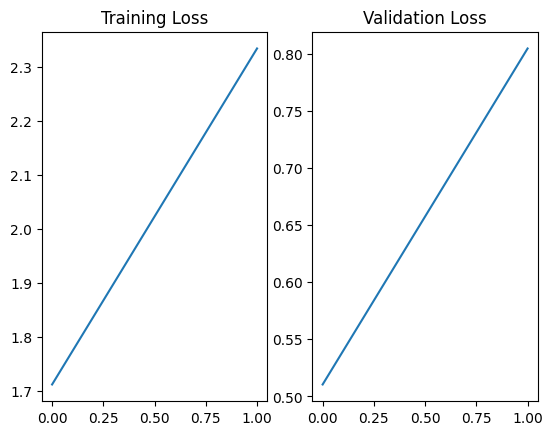

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2,)
axes[0].plot(train_hist)
axes[0].set_title('Training Loss')

axes[1].plot(val_hist)
axes[1].set_title('Validation Loss')

In [83]:
MODEL.save_pretrained("./finqa_finetune_t5.pth")